In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pingouin as pg
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import math
import seaborn as sns
import scipy.stats

In [3]:
input_dir='/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Crispr/data/Behavior_test/DerivedData/'
file = 'Zone_behavior_test_ksr2_crispr_20230317.xlsx'
date = file.split('/')[-1].split('.')[0].split('_')[-1]
df_zone = pd.read_excel(input_dir+file)
df_zone['Fish_ID'] = df_zone.loc[:, (df_zone.columns.str.endswith('Pcolumn')|df_zone.columns.str.endswith('Prow'))].astype('str').agg(''.join, axis=1)
df_zone['Fish_ID'] = date+'-'+'Plate'+df_zone.loc[:,(df_zone.columns.str.endswith('Plate')|df_zone.columns.str.endswith('Fish_ID'))].astype('str').agg('-'.join, axis=1)
df_zone = df_zone.loc[:,['Unnamed: 3','Distance moved center-point Total mm','Fish_ID']]
df_zone = df_zone.loc[df_zone['Unnamed: 3']=='In D'].iloc[:, 1:]
df_zone.rename(columns={df_zone.columns[0]:'DZTD'}, inplace=True)
df_zone.set_index('Fish_ID', inplace=True)
df_zone.replace('-', 0, inplace=True)
df_zone = df_zone.groupby('Fish_ID').mean()
df_zone

,DZTD
Fish_ID,
20230317-Plate1-10A,354.65710
20230317-Plate1-10B,556.10525
20230317-Plate1-10C,473.11925
20230317-Plate1-10D,370.00625
20230317-Plate1-10E,557.45400
...,...
20230317-Plate2-9D,564.38725
20230317-Plate2-9E,552.26550
20230317-Plate2-9F,861.90800


In [4]:
def zone_process(input_dir, file):  
    df_zone = pd.read_excel(input_dir+file)
    date = file.split('/')[-1].split('.')[0].split('_')[-1]
    df_zone['Fish_ID'] = df_zone.loc[:, (df_zone.columns.str.endswith('Pcolumn')|df_zone.columns.str.endswith('Prow'))].astype('str').agg(''.join, axis=1)
    df_zone['Fish_ID'] = date+'-'+'Plate'+df_zone.loc[:,(df_zone.columns.str.endswith('Plate')|df_zone.columns.str.endswith('Fish_ID'))].astype('str').agg('-'.join, axis=1)
    df_zone = df_zone.loc[:,['Unnamed: 3','Distance moved center-point Total mm','Fish_ID']]
    df_zone = df_zone.loc[df_zone['Unnamed: 3']=='In D'].iloc[:, 1:]
    df_zone.rename(columns={df_zone.columns[0]:'DZTD'}, inplace=True)
    df_zone.set_index('Fish_ID', inplace=True)
    df_zone.replace('-', 0, inplace=True)
    df_zone = df_zone.groupby('Fish_ID').mean()
    return df_zone
input_dir = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Crispr/data/Behavior_test/DerivedData/'
dfs = []
for file in os.listdir(input_dir):
    if file.startswith('Zone_behavior'):
        print(file)
        df = zone_process(input_dir, file)
        dfs.append(df)
df_zone = pd.concat(dfs)
df_zone

Zone_behavior_test_htr1b_crispr_20220708.xlsx
Zone_behavior_test_impg1b_crispr_20220720.xlsx


/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Zone_behavior_test_ypel1_crispr_20221110.xlsx
Zone_behavior_test_eh1nos1_crispr_20230227.xlsx
Zone_behavior_test_ksr2_crispr_20230317.xlsx
Zone_behavior_test_stip1_crispr_20220916.xlsx
Zone_behavior_test_eh1_crispr_20221121.xlsx
Zone_behavior_test_htr1b_crispr_20220706.xlsx
Zone_behavior_test_rps6ka4_crispr_20220921.xlsx
Zone_behavior_test_nos1_crispr_20220805.xlsx
Zone_behavior_test_il11a_crispr_20220611.xlsx


,DZTD
Fish_ID,
20220708-Plate1-1A,309.840500
20220708-Plate1-1B,241.903750
20220708-Plate1-1C,311.373798
20220708-Plate1-1D,406.091500
20220708-Plate1-1E,399.097250
...,...
20220611-Plate2-9D,660.560750
20220611-Plate2-9E,180.931373
20220611-Plate2-9F,413.358632


In [5]:
input_data = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Crispr/data/Behavior_test/DerivedData/Crispr_behavior_test_summary.xlsx'
df_mean_stats = pd.read_excel(input_data, sheet_name=0, index_col=0)
df_mean_stats = pd.concat((df_mean_stats, df_zone), axis=1)
df_mean_stats = df_mean_stats.dropna()
df_mean_stats = df_mean_stats.iloc[:, [0,1,2,3,4,5,-1,6,7,8,9,10,11,12]]


In [6]:
def outliers(x):
        Q1 = x.quantile(0.25)
        Q3 = x.quantile(0.75)
        IQR = Q3 - Q1
        limit1 = Q1 - 1.5*IQR
        limit2 = Q3 + 1.5*IQR
        return x[(x>limit1)&(x<limit2)]
def zscore(x):
    return (x-x.mean())/x.std()
df_all_norm_list = []
for i in range(len(list(df_mean_stats.groupby(['Cat', 'Gene'])))):
    cat = list(df_mean_stats.groupby(['Cat', 'Gene']))[i][0][0]
    gene = list(df_mean_stats.groupby(['Cat', 'Gene']))[i][0][1]
    df = list(df_mean_stats.groupby(['Cat', 'Gene']))[i][1]
    df_norm_list = []
    for trait in df_mean_stats.columns[:-3]:
        df_norm_list.append(outliers(df[trait]))
    df_norm = pd.concat(df_norm_list,axis=1)
    df_norm['Cat'] = cat
    df_norm['Gene'] = gene
    df_all_norm_list.append(df_norm)
df_mean_stats = pd.concat(df_all_norm_list)
df_mean_stats


,LDCI,TDEN,ADED,LFDE,Velocity,TD,DZTD,T1_LDCI,T2_LDCI,T3_LDCI,T4_LDCI,Cat,Gene
Fish_ID,,,,,,,,,,,,,
20221110-Plate2-1D,-0.988734,2.00,2.703757,199.172333,2.367005,1154.64100,32.270467,-0.984165,-0.998771,-0.972002,-1.000000,Cas9,ypel1
20221110-Plate2-1H,-0.633141,13.50,13.043875,44.084850,3.569795,1741.52750,612.347500,-0.662690,-0.777592,-0.632614,-0.459667,Cas9,ypel1
20221110-Plate2-2D,-0.533592,8.25,27.136445,46.495602,3.019835,1469.10750,608.531750,-0.742318,-0.507306,-0.694544,-0.190201,Cas9,ypel1
20221110-Plate2-2H,-0.828223,6.25,13.192494,36.085345,2.948263,1434.31250,331.100300,-0.759712,-0.765562,-0.793508,-0.994109,Cas9,ypel1
20221110-Plate2-3D,-0.892365,5.25,9.840873,28.906067,1.854942,904.52975,136.598950,-0.864262,-0.820508,-1.000000,-0.884693,Cas9,ypel1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20221110-Plate2-10C,-0.784197,5.50,18.833759,121.352375,3.061260,1493.03750,282.831500,-0.899904,-0.756493,-0.612873,-0.867516,RNP,ypel1
20221110-Plate2-10E,-0.862859,5.00,13.165504,113.060500,2.696370,1272.82925,192.742000,-0.951982,-0.907880,-0.825778,-0.765798,RNP,ypel1
20221110-Plate2-10G,-0.701112,9.00,15.940709,84.916495,2.574805,1256.19800,280.461000,-0.735680,-0.888006,-0.853553,-0.327208,RNP,ypel1


In [7]:
df_all_norm_list = []
for gene in df_mean_stats['Gene'].unique():
    df_norm_list = []
    for trait in df_mean_stats.columns[:-2]:
        df = df_mean_stats.loc[df_mean_stats['Gene']==gene][trait].dropna()
        df_norm_list.append(zscore(df))
    df_norm = pd.concat(df_norm_list,axis=1)
    df_norm['Gene'] = gene
    df_all_norm_list.append(df_norm)
df_normalized_stats = pd.concat(df_all_norm_list)
df_normalized_stats = pd.concat((df_normalized_stats, df_mean_stats['Cat']), axis=1)


### Compare Cas9 only injected group with control group

In [8]:

df_test_cas9 = df_normalized_stats.loc[df_normalized_stats['Gene'] == 'ypel1']
df_test_cas9 = df_test_cas9.loc[df_test_cas9.index.str.contains('Plate2')]
res_list = []
for param in df_test_cas9.columns[:-2]:
    res = pg.ttest(x = df_test_cas9.loc[df_test_cas9['Cat']=='Cas9'][param], y=df_test_cas9.loc[df_test_cas9['Cat']=='Control'][param])
    res_list.append(res)
df_cas9_res = pd.concat(res_list)
df_cas9_res['pval_adjust'] = pg.multicomp(df_cas9_res['p-val'], method = 'fdr_bh', )[1]    
df_cas9_res.index = df_test_cas9.columns[:-2]
df_cas9_res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,pval_adjust
LDCI,-1.163726,48.517332,two-sided,0.250226,"[-0.95, 0.25]",0.318141,0.482,0.205994,0.458748
TDEN,-1.363717,48.468554,two-sided,0.178957,"[-0.95, 0.18]",0.374756,0.596,0.263019,0.393705
ADED,0.506208,45.792607,two-sided,0.615139,"[-0.44, 0.74]",0.142360,0.317,0.077611,0.676653
LFDE,1.991958,38.530701,two-sided,0.053497,"[-0.01, 1.19]",0.563286,1.4,0.488398,0.196155
Velocity,1.049716,43.376723,two-sided,0.299662,"[-0.22, 0.69]",0.295937,0.441,0.179091,0.470898
TD,-0.067268,39.487593,two-sided,0.946707,"[-0.54, 0.5]",0.018281,0.277,0.050488,0.946707
DZTD,-0.711672,45.707598,two-sided,0.480285,"[-0.72, 0.34]",0.194136,0.341,0.106626,0.587015
T1_LDCI,-3.325878,50.000000,two-sided,0.001657,"[-1.44, -0.36]",0.922433,20.467,0.903437,0.018229
T2_LDCI,0.777922,48.291726,two-sided,0.440410,"[-0.38, 0.86]",0.212626,0.355,0.118220,0.587015
T3_LDCI,-2.122018,50.761227,two-sided,0.038738,"[-1.39, -0.04]",0.581869,1.709,0.546884,0.196155


In [92]:
df_test_cas9['Cat'].unique()

array(['Cas9', 'Control', 'RNP'], dtype=object)

In [95]:
df_plot.loc[df_plot['Cat']=='Cas9'].shape

(27, 3)

In [96]:
df_plot.loc[df_plot['Cat']=='Control'].shape

(26, 3)

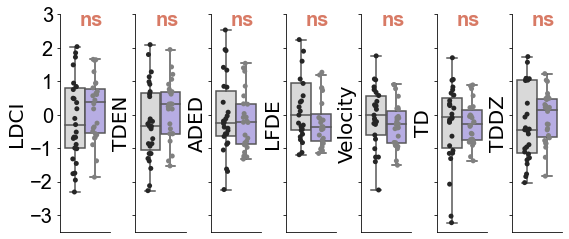

In [89]:
fig, ax = plt.subplots(1, 7, figsize=(9, 4), sharey=True)
plt.rcParams['xtick.bottom'] = False
plt.subplots_adjust(wspace=0.5)
df_test_cas9.rename(columns={'DZTD':'TDDZ'},inplace=True)
fontsize = 20
for i, trait in enumerate(df_test_cas9.columns[:7]):
    df_plot = df_test_cas9[[trait, 'Cat', 'Gene']]
    df_plot = df_plot.loc[df_plot['Cat']!='RNP']
    sns.stripplot(x='Gene', y=trait, hue='Cat',data=df_plot, 
                  jitter=True,dodge=True, marker='o', color='gray', edgecolor='gray',
                  ax=ax[i], size=5)
    
    sns.boxplot(x='Gene', y=trait, hue='Cat',
                data=df_plot, ax=ax[i], showfliers = False, color='#cd834d',
                width=0.8)
    ax[i].legend("",frameon=False, loc = [0, 0.9])
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_ylim(-3.5, 3)
    ax[i].set_ylabel(trait, fontsize=fontsize)
    ax[i].set_xlabel("")
    for box1, box2 in zip(ax[i].artists[::2],ax[i].artists[1::2]):
        box1.set_facecolor('#D9D9D9')
        box2.set_facecolor('#B7ADE3')
    ax[i].set_xticklabels([""])
    ax[i].text(0.4,0.95,'ns',transform = ax[i].transAxes, 
               color='#d87a65', size=fontsize, fontweight="bold", fontname = "Arial")
    for tick in ax[i].get_xticklabels():
        tick.set_fontname("Arial")
        tick.set_fontsize(fontsize)
    for tick in ax[i].get_yticklabels():
        tick.set_fontname("Arial")
        tick.set_fontsize(fontsize)

### Compare RNP injected group with Control group

In [11]:
### define a function of statistical test for each gene for each parameter
### adjust p-val with FDR_bh method
def stats_test(df):
    def symbolize(x):
        if x>0.05:
            return 'ns'
        elif x>0.01:
            return '*'
        elif x>0.001:
            return '**'
        elif x>0.0001:
            return '*'*3

        else:
            return '*'*5
    
    com_res = []
    for j, param in enumerate(df.columns[:-2]):
        if param == 'T2_LDCI':
            results = pg.ancova(data=df, dv=param, covar = 'T1_LDCI', between='Cat').round(3)
        elif param == 'T4_LDCI':
            results = pg.ancova(data=df, dv=param, covar = 'T3_LDCI', between='Cat').round(3)
        else:
            results = pg.anova(data=df, dv=param, between='Cat').round(3)
        results['parameter'] = param
        results = results.loc[results['Source']=='Cat']
        com_res.append(results)
    df_com_res = pd.concat(com_res)
    df_com_res['pval_adjust'] = pg.multicomp(df_com_res['p-unc'], method = 'fdr_bh', )[1]
    df_com_res['significance'] = df_com_res['pval_adjust'].apply(symbolize)
    return df_com_res

### apply the above function to all the genes
dic_stats_test = {}
for gene in df_normalized_stats['Gene'].unique():
    res = stats_test(df_normalized_stats.loc[(df_normalized_stats['Gene']==gene)&(df_normalized_stats['Cat']!='Cas9')])
    dic_stats_test.update({gene:res})

In [12]:
for gene in df_normalized_stats['Gene'].unique():
    print(gene)
    print(df_mean_stats.loc[df_normalized_stats['Gene']==gene].shape[0])

ypel1
187
eh1_AB
16
eh1_AC
41
eh1_AK
66
eh1nos1
185
htr1b
44
il11a
134
impg1b
83
ksr2
55
nos1
117
rps6ka4
43
stip1
89


/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


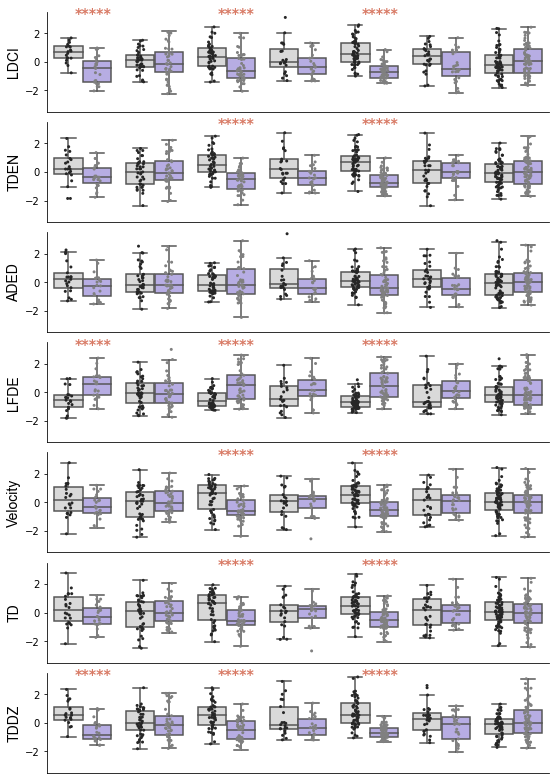

In [64]:
df_normalized_stats_sub = df_normalized_stats.loc[df_normalized_stats['Cat']!='Cas9']
gene_order = ['htr1b','impg1b','stip1','rps6ka4','nos1','ksr2','il11a']
df_normalized_stats_sub['Gene_cat'] = pd.Categorical(
    df_normalized_stats_sub['Gene'], 
    categories=gene_order, 
    ordered=True
)
traitlist = df_normalized_stats_sub.columns[:7]
df_normalized_stats_sub = df_normalized_stats_sub.loc[df_normalized_stats_sub['Gene'].isin(gene_order)]
df_normalized_stats_sub = df_normalized_stats_sub.sort_values('Gene_cat')
fig, ax = plt.subplots(len(traitlist), 1, figsize=(9, 14))
plt.subplots_adjust(hspace=0.1)
for i, trait in enumerate(traitlist):
    df_plot = df_normalized_stats_sub[[trait, 'Cat', 'Gene']]
    sns.stripplot(x='Gene', y=trait, hue='Cat',data=df_plot, 
                  jitter=True,dodge=True, marker='o', color='grey', edgecolor='grey',
                  ax=ax[i], size=3)
    
    sns.boxplot(x='Gene', y=trait, hue='Cat',
                data=df_plot, ax=ax[i], showfliers = False, color='#cd834d',
                width=0.8)
    ax[i].legend("",frameon=False, loc = [0, 0.9])
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_ylim(-3.5, 3.5)
    for box1, box2 in zip(ax[i].artists[::2],ax[i].artists[1::2]):
        box1.set_facecolor('#D9D9D9')
        box2.set_facecolor('#B7ADE3')
    ax[i].set_xticks(np.arange(0,len(gene_order)))
    if i<(len(traitlist)-1):
        ax[i].set_xticklabels([""]*(len(gene_order)))
        ax[i].set_ylabel(trait, size=14, fontname='Arial')
    else:
        ax[i].set_xticklabels([""]*(len(gene_order)))
        ax[i].set_ylabel('TDDZ', size=14, fontname='Arial')
    ax[i].set_xlabel("")
    
    symbol_list= []
    for gene in gene_order:
        x=gene_order.index(gene)*(1/len(gene_order))+0.055
        y=0.99
        df_temp = dic_stats_test[gene]
        symbol = df_temp.loc[df_temp['parameter']==trait].iloc[0,-1]
        if symbol != 'ns':
            ax[i].text(x,y-0.05,symbol,transform = ax[i].transAxes, color='#d87a65', size=14, fontweight="bold")
    
plt.show()

In [67]:
df_normalized_stats_sub = df_normalized_stats.loc[df_normalized_stats['Cat']!='Cas9']
df_normalized_stats_sub['Gene_cat'] = df_normalized_stats_sub['Gene']+df_normalized_stats_sub['Cat']

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [72]:
df_normalized_stats_sub = df_normalized_stats.loc[df_normalized_stats['Cat']!='Cas9']
gene_order = ['nos1','eh1nos1','ksr2']
df_normalized_stats_sub.loc[:,'Gene_cat'] = pd.Categorical(
    df_normalized_stats_sub.loc[:,'Gene'], 
    categories=gene_order, 
    ordered=True
)

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [88]:
df_normalized_stats_sub.rename(columns={'DZTD':'TDDZ'})

,LDCI,TDEN,ADED,LFDE,Velocity,TD,TDDZ,T1_LDCI,T2_LDCI,T3_LDCI,T4_LDCI,Gene,Cat,Gene_cat
Fish_ID,,,,,,,,,,,,,,
20220706-Plate1-1B,0.749177,1.438143,0.088045,0.578525,0.456251,0.462439,0.177313,0.616142,0.338533,1.188674,0.132755,htr1b,Control,htr1b
20220706-Plate1-2C,-0.759480,-1.111119,0.241160,0.086687,-1.163014,-1.147889,-0.671274,1.538277,-1.336540,-0.631694,-0.002121,htr1b,RNP,htr1b
20220706-Plate1-2E,0.421539,0.451332,0.048356,0.173936,0.532185,0.535294,0.889593,NaN,0.538745,-0.631694,0.048903,htr1b,RNP,htr1b
20220706-Plate1-2G,-1.536759,-0.371010,-1.391837,1.643471,0.002022,0.005249,-1.280097,-0.574244,-0.587542,-0.631694,-1.310287,htr1b,RNP,htr1b
20220706-Plate1-3A,-0.145131,-0.946650,NaN,-0.204802,-0.761994,-0.777503,-0.729612,-0.267751,-1.190228,NaN,0.021673,htr1b,RNP,htr1b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20220611-Plate2-8C,-0.630585,0.649764,-0.975297,0.298826,0.245128,0.254938,-0.368551,-0.308155,-0.610944,-0.114981,-0.610893,il11a,RNP,il11a
20220611-Plate2-8B,-0.417873,0.649764,-1.248545,-0.497969,-0.255762,-0.239974,-0.142564,-0.242002,-1.385636,-0.279362,0.790549,il11a,RNP,il11a
20220611-Plate2-8A,1.311156,1.041999,0.667964,-0.997233,-1.066346,-1.080843,0.825696,1.366257,0.705980,1.066937,0.808378,il11a,RNP,il11a


/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


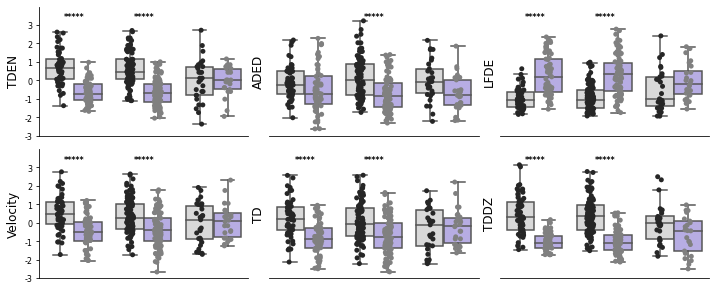

In [88]:
df_normalized_stats_sub = df_normalized_stats.loc[df_normalized_stats['Cat']!='Cas9']
gene_order = ['nos1','eh1nos1','ksr2']
df_normalized_stats_sub.loc[:,'Gene_cat'] = pd.Categorical(
    df_normalized_stats_sub.loc[:,'Gene'], 
    categories=gene_order, 
    ordered=True
)


df_normalized_stats_sub = df_normalized_stats_sub.loc[df_normalized_stats_sub['Gene'].isin(gene_order)]
df_normalized_stats_sub = df_normalized_stats_sub.sort_values(['Gene_cat', 'Cat'])
traitlist = df_normalized_stats_sub.columns[1:7].to_list()
fig, ax = plt.subplots(2, round(len(traitlist)/2), figsize=(12, 5), sharex=True)
plt.subplots_adjust(hspace=0.1,wspace=0.1)

for i, trait in enumerate(traitlist):
    df_plot = df_normalized_stats_sub.copy().loc[:,[trait, 'Cat', 'Gene']]
    sns.stripplot(x='Gene', y=trait, hue='Cat',data=df_plot, 
                  jitter=True,dodge=True, marker='o', color='gray', edgecolor='gray',
                  ax=ax[i//3][i%3], size=5)
    
    sns.boxplot(x='Gene', y=trait, hue='Cat',
                data=df_plot, ax=ax[i//3][i%3], showfliers = False, color='#cd834d',
                width=0.8, dodge=True)
    ax[i//3][i%3].legend("",frameon=False, loc = [0, 0.9])
    ax[i//3][i%3].spines['right'].set_visible(False)
    ax[i//3][i%3].spines['top'].set_visible(False)
    ax[i//3][i%3].set_ylim(-2.5, 4)
    for box1, box2 in zip(ax[i//3][i%3].artists[::2],ax[i//3][i%3].artists[1::2]):
        box1.set_facecolor('#D9D9D9')
        box2.set_facecolor('#B7ADE3')
    ax[i//3][i%3].set_xticks(np.arange(0,len(gene_order)))
    ax[i//3][i%3].set_xticklabels([""]*(len(gene_order)))
    ax[i//3][i%3].set_xlabel("")

    symbol_list= []
    if i%3==0:

        ax[i//3][i%3].set_yticks(np.arange(-3,4,1))
        ax[i//3][i%3].set_yticklabels(np.arange(-3,4,1).round(1), size=8)
    else:
        ax[i//3][i%3].axes.yaxis.set_ticks([])
        #ax[i//3][i%3].set_yticks([])
        ax[i//3][i%3].spines['left'].set_visible(False)
    for gene in gene_order:
        x=gene_order.index(gene)*(1/len(gene_order))+0.12
        y=0.9
        df_temp = dic_stats_test[gene]
        symbol = df_temp.loc[df_temp['parameter']==trait].iloc[0,-1]
        if symbol != 'ns':
            ax[i//3][i%3].text(x,y,symbol,transform = ax[i//3][i%3].transAxes, color='#000000', size=8, fontweight="bold")
    if trait == traitlist[-1]:
        trait = 'TDDZ'
    ax[i//3][i%3].set_ylabel(trait,size=12)
plt.show()

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


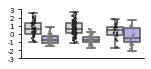

In [124]:
df_normalized_stats_sub = df_normalized_stats.loc[df_normalized_stats['Cat']!='Cas9']
gene_order = ['nos1','eh1nos1','ksr2']
df_normalized_stats_sub['Gene_cat'] = pd.Categorical(
    df_normalized_stats_sub['Gene'], 
    categories=gene_order, 
    ordered=True
)
traitlist = df_normalized_stats_sub.columns[:1]
df_normalized_stats_sub = df_normalized_stats_sub.loc[df_normalized_stats_sub['Gene'].isin(gene_order)]
df_normalized_stats_sub = df_normalized_stats_sub.sort_values(['Gene_cat', 'Cat'])
fig, ax = plt.subplots(len(traitlist), 1, figsize=(2.2, 0.9))
plt.subplots_adjust(hspace=0.6)
for i, trait in enumerate(traitlist):
    df_plot = df_normalized_stats_sub[[trait, 'Cat', 'Gene']]
    sns.stripplot(x='Gene', y=trait, hue='Cat',data=df_plot, 
                  jitter=True,dodge=True, marker='o', color='grey', edgecolor='grey',
                  ax=ax, size=2)
    
    sns.boxplot(x='Gene', y=trait, hue='Cat',
                data=df_plot, ax=ax, showfliers = False, color='#cd834d',
                width=0.8, dodge=True)
    ax.legend("",frameon=False, loc = [0, 0.9])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(-3, 3)
    for box1, box2 in zip(ax.artists[::2],ax.artists[1::2]):
        box1.set_facecolor('#D9D9D9')
        box2.set_facecolor('#B7ADE3')
    ax.set_xticks(np.arange(0,len(gene_order)))
    ax.set_xticklabels([""]*(len(gene_order)))
    ax.set_yticks(np.arange(-3,4,1))
    ax.set_yticklabels(np.arange(-3,4,1), fontsize=7)
    ax.set_xlabel("")
    ax.set_ylabel("")
    symbol_list= []

wdir = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/doc/Figures/Initial_submit/'    
plt.show()
fig.savefig(wdir+'Figure 6B.tiff', dpi=300, bbox_inches='tight')

In [68]:
df_bin_list = [] 
input_dir = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Crispr/data/Behavior_test/DerivedData/'
for file in os.listdir(input_dir):
    for gene in df_mean_stats['Gene'].unique():
        if file.startswith('Bin_behavior'):
            if file.split("_")[3]==gene:
                print(file)
                df_bin = pd.read_excel(input_dir+file)
                date = file.split('/')[-1].split('.')[0].split('_')[-1]
                df_bin['Fish_ID'] = df_bin.loc[:, (df_bin.columns.str.endswith('Pcolumn')|df_bin.columns.str.endswith('Prow'))].astype('str').agg(''.join, axis=1)
                df_bin['Fish_ID'] = date+'-'+'Plate'+df_bin.loc[:,(df_bin.columns.str.endswith('Plate')|df_bin.columns.str.endswith('Fish_ID'))].astype('str').agg('-'.join, axis=1)
                df_bin['Time_bin'] = df_bin['Unnamed: 3'].str.replace('Start', "0:00:00")
                df_bin['Time_bin'] = df_bin.loc[:,(df_bin.columns.str.endswith('Trial')|df_bin.columns.str.endswith('Time_bin'))].astype('str').agg('-'.join, axis=1)
                df_bin = df_bin.loc[df_bin['In zone D / center-point Cumulative Duration s']!='-']
                df_bin['Adjusted_D_zone_duration'] = 30*df_bin['In zone D / center-point Cumulative Duration s'].astype('float64')/(df_bin['In zone L / center-point Cumulative Duration s'].astype('float64')+df_bin['In zone D / center-point Cumulative Duration s'].astype('float64'))
                df_bin['LDCI'] = df_bin['Adjusted_D_zone_duration'].apply(lambda x: (2*x-30)/30)
                df_bin_list.append(df_bin.iloc[:,-4:])
df_bin_stats = pd.concat(df_bin_list)   
    
    

Bin_behavior_test_rps6ka4_crispr_20220921.xlsx
Bin_behavior_test_ypel1_crispr_20221110.xlsx
Bin_behavior_test_stip1_crispr_20220916.xlsx
Bin_behavior_test_htr1b_crispr_20220706.xlsx
Bin_behavior_test_eh1nos1_crispr_20230227.xlsx
Bin_behavior_test_il11a_crispr_20220611.xlsx
Bin_behavior_test_htr1b_crispr_20220708.xlsx
Bin_behavior_test_nos1_crispr_20220805.xlsx
Bin_behavior_test_impg1b_crispr_20220720.xlsx
Bin_behavior_test_ksr2_crispr_20230317.xlsx


In [70]:
dfs_bin_ldci = []
for timebin in df_bin_stats['Time_bin'].unique():
    dfs_bin_ldci.append(df_bin_stats.loc[df_bin_stats['Time_bin']==timebin].set_index('Fish_ID')['LDCI'])
    
df_bin_ldci = pd.concat(dfs_bin_ldci, axis=1)
df_bin_ldci.columns=df_bin_stats['Time_bin'].unique()
df_bin_ldci = df_bin_ldci.loc[df_mean_stats.index.intersection(df_bin_ldci.index)]
df_bin_ldci = pd.concat((df_bin_ldci, df_mean_stats[['Cat', 'Gene']]),axis=1)
df_bin_ldci

,1-0:00:00-0:00:30,1-0:00:30-0:01:00,1-0:01:00-0:01:30,1-0:01:30-0:02:00,1-0:02:00-0:02:30,1-0:02:30-0:03:00,1-0:03:00-0:03:30,1-0:03:30-0:04:00,1-0:04:00-0:04:30,1-0:04:30-0:05:00,...,4-0:04:00-0:04:30,4-0:04:30-0:05:00,4-0:05:00-0:05:30,4-0:05:30-0:06:00,4-0:06:00-0:06:30,4-0:06:30-0:07:00,4-0:07:00-0:07:30,4-0:07:30-0:08:00,Cat,Gene
Fish_ID,,,,,,,,,,,,,,,,,,,,,
20221110-Plate2-1D,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,Cas9,ypel1
20221110-Plate2-1H,-1.0,-1.000000,-0.965032,-1.000000,-0.846219,-0.484755,-0.387926,-0.696380,-0.577227,0.195469,...,0.738489,0.435694,0.388237,1.000000,1.000000,0.024985,0.786726,0.383377,Cas9,ypel1
20221110-Plate2-2D,-1.0,-1.000000,-1.000000,0.153233,-0.477262,-1.000000,0.340865,-0.229473,0.094730,0.057659,...,1.000000,1.000000,0.446025,0.489169,1.000000,1.000000,1.000000,1.000000,Cas9,ypel1
20221110-Plate2-2H,-1.0,-1.000000,-0.453611,-1.000000,-0.808095,-0.377512,-0.727986,-1.000000,-0.696410,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,Cas9,ypel1
20221110-Plate2-3D,-1.0,-0.712427,-1.000000,-1.000000,-0.709928,-0.809135,-0.374406,-0.089462,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-0.166047,-1.000000,-1.000000,-1.000000,Cas9,ypel1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20221121-Plate2-5B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RNP,eh1_AK
20221121-Plate2-5F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RNP,eh1_AK
20221121-Plate2-6B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RNP,eh1_AK


### LDCI dynamic similarity test

### method 1: sum of deviation 

In [103]:
ss_dic = {}
for gene in ['htr1b','nos1','eh1nos1','stip1','impg1b','il11a','rps6ka4','ksr2']:
    ss_list = []
    for trial in range (1,5):
        trial = str(trial)+'-'
        df_control = df_bin_ldci.iloc[:,df_bin_ldci.columns.str.startswith(trial)].\
        loc[(df_bin_ldci['Gene']== gene)&(df_bin_ldci['Cat']=='Control')]
    
        df_rnp = df_bin_ldci.iloc[:,df_bin_ldci.columns.str.startswith(trial)].\
        loc[(df_bin_ldci['Gene']== gene)&(df_bin_ldci['Cat']=='RNP')]
    
        #ss = ((df_control.mean()-df_rnp.mean())**2).sum()
        ss = (abs(df_control.mean()-df_rnp.mean())).sum()
        ss_list.append(ss)
    ss_dic.update({gene:ss_list})
df_ss = pd.DataFrame(ss_dic, index = [1,2,3,4])
    

In [104]:
df_ss

,htr1b,nos1,eh1nos1,stip1,impg1b,il11a,rps6ka4,ksr2
1,2.106446,6.015455,5.084804,4.351452,1.012055,1.045870,4.572667,2.319661
2,3.862891,8.399155,8.565976,2.629915,1.023711,0.754602,3.952688,2.489093
3,2.498146,3.253542,5.549253,4.917329,0.979023,1.437973,1.431025,3.948619
4,3.653998,4.923419,4.200260,2.264664,1.779883,1.515081,1.772867,1.925441


In [66]:
df_pop_bin_ldci = pd.read_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Behavior_test/DerivedData/20220822/Accumulative_bin_20201222.csv',)

df_pop_bin_ldci = df_pop_bin_ldci.set_index('Fish_ID')

In [94]:
ss_stats_dic = {}

for i in range (0, 1000):
    ss_pop_list= []
    df_pop = df_pop_bin_ldci.sample(100)
    for trial in range(1,5):
        
        trial = str(trial)+'-'
        df_pop1 = df_pop.iloc[:50,df_pop.columns.str.startswith(trial)].mean()
        df_pop2 = df_pop.iloc[50:,df_pop.columns.str.startswith(trial)].mean()
        #ss_pop = ((df_pop1-df_pop2)**2).sum()
        ss_pop = (abs(df_pop1-df_pop2)).sum()
        ss_pop_list.append(ss_pop)
    ss_stats_dic.update({i:ss_pop_list})

In [106]:
df_pop_mean = pd.DataFrame(ss_stats_dic, index=[1,2,3,4]).mean(axis=1)
df_pop_std = pd.DataFrame(ss_stats_dic,index=[1,2,3,4]).std(axis=1)
df_pop_stats = pd.concat((df_pop_mean,df_pop_std),axis=1)
df_pop_stats.columns = ['pop_mean', 'pop_std']

In [254]:
df_test = pd.concat((df_ss,df_pop_stats), axis=1)

In [257]:
p_value_list = []
for gene in df_test.columns[:8]:
    z_score = (df_test[gene]-df_test['pop_mean'])/df_test['pop_std']
    p_value = z_score.apply(lambda x: scipy.stats.norm.sf(abs(x))*2)
    p_value = pd.Series(pg.multicomp(p_value, method='bonf')[1], name=gene)
    p_value = p_value.apply(lambda x: math.log(x,10)*(-1))
    p_value_list.append(p_value)
df_res = pd.concat(p_value_list,axis=1)
df_res.columns = df_test.columns[:8]

In [258]:
df_res

,htr1b,nos1,eh1nos1,stip1,impg1b,il11a,rps6ka4,ksr2
0,0.426921,21.603901,13.992836,9.139686,-0.0,-0.000000,10.497792,0.869952
1,5.443920,43.791612,45.893930,1.202728,-0.0,0.173692,5.853640,0.878594
2,1.109580,3.519874,17.589458,12.686950,-0.0,-0.000000,-0.000000,6.694957
3,3.206290,8.403590,5.163954,0.060183,-0.0,-0.000000,-0.000000,-0.000000


In [259]:
def pvalue_symbol(pvalue):
    if pvalue < 2:
        return 'ns'
    elif pvalue >= 2 and pvalue <= 4:
        return '*'*(int(pvalue//1))
    else:
        return '*'*5

In [261]:
df_res_symbol = df_res.applymap(lambda x: pvalue_symbol(x))
df_res_symbol

,htr1b,nos1,eh1nos1,stip1,impg1b,il11a,rps6ka4,ksr2
0,ns,*****,*****,*****,ns,ns,*****,ns
1,*****,*****,*****,ns,ns,ns,*****,ns
2,ns,***,*****,*****,ns,ns,ns,*****
3,***,*****,*****,ns,ns,ns,ns,ns


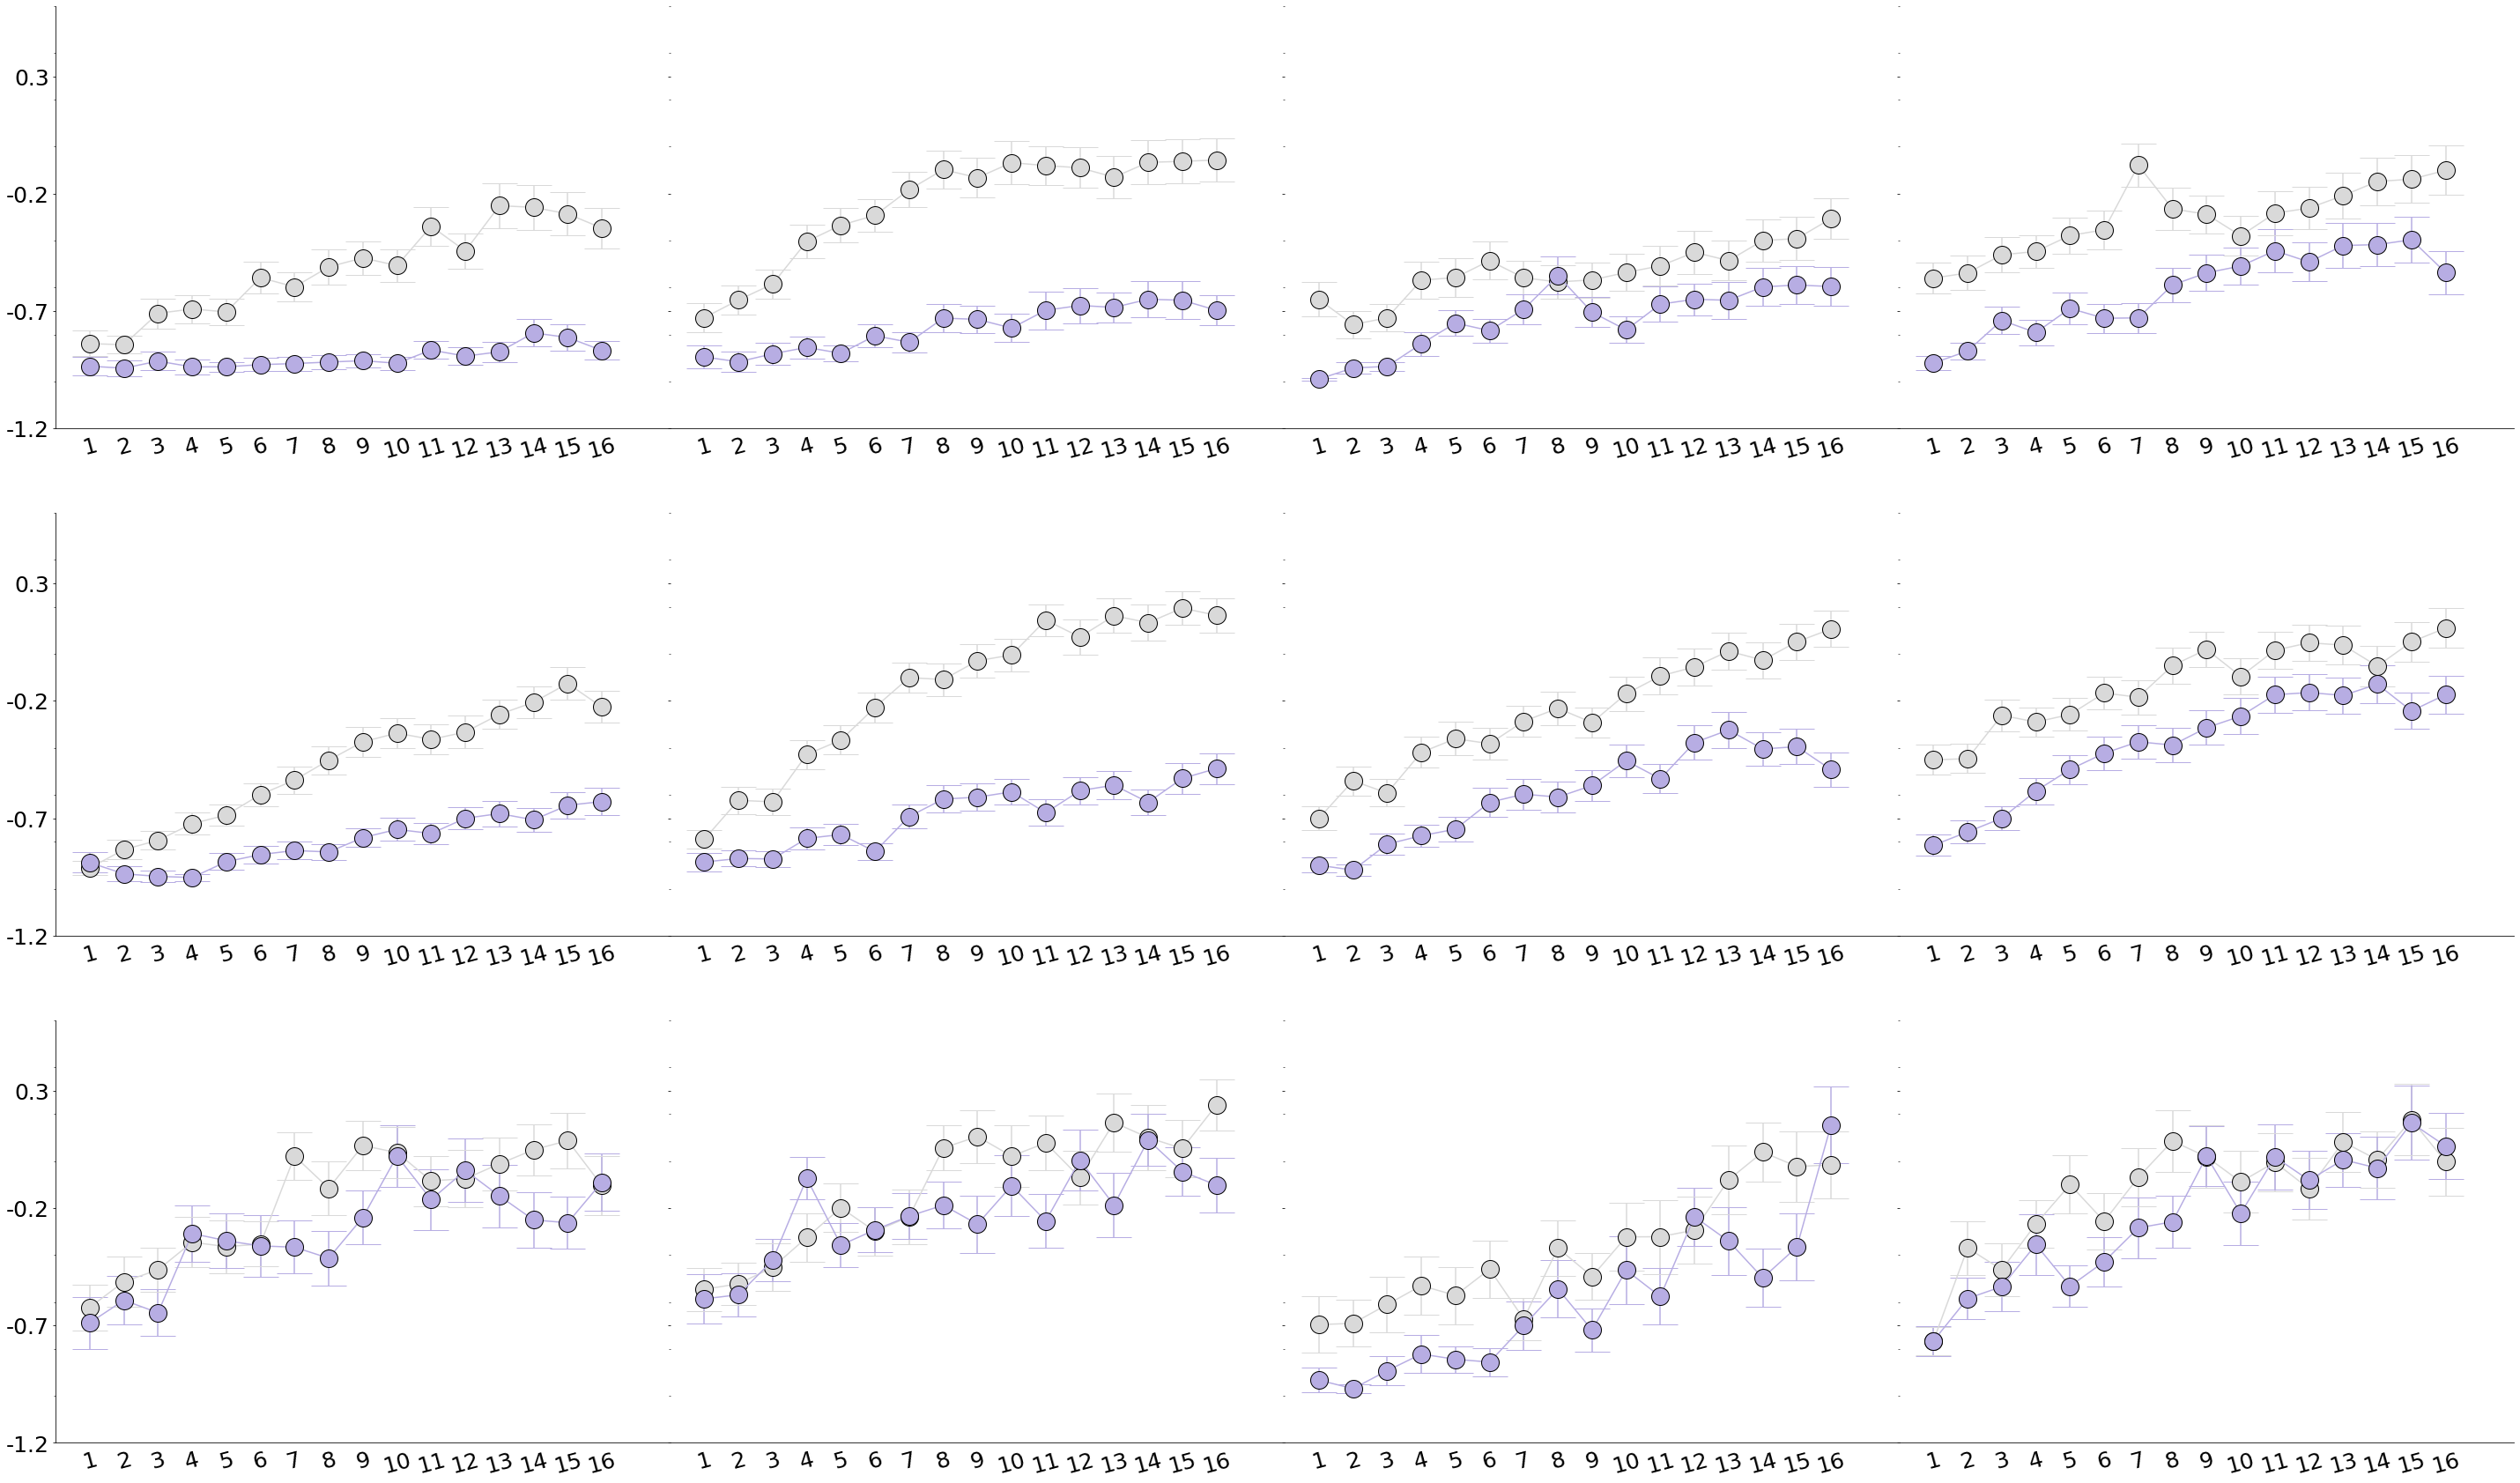

In [78]:
gene_order = ['nos1','eh1nos1','ksr2']
fig, ax = plt.subplots(len(gene_order),4,figsize=(50,30),sharey=True)
plt.subplots_adjust(hspace=0.2, wspace=0.0)
colors = ['#D9D9D9','#B7ADE3']
for i, gene in enumerate(gene_order):
    df = df_bin_ldci.loc[df_bin_ldci['Gene']==gene]
    for trial in range(4):
        for group in ['Control', 'RNP']:
            df_bin_ci = df.loc[df['Cat']== group]
            df_bin_ci = df_bin_ci.loc[:, df_bin_ci.columns.str.contains(str(trial+1)+'-')]
            df_bin_ci.mean().plot(marker='o',yerr=df_bin_ci.sem(), ax = ax[i][trial],capsize=20,label=group, 
                                  color=colors[['Control', 'RNP'].index(group)], mec='black', markersize=20)

            
            ax[i][trial].spines['top'].set_visible(False)
            ax[i][trial].spines['right'].set_visible(False)
            if trial>0:
                ax[i][trial].legend("",frameon=False, loc='upper left')
                ax[i][trial].spines['left'].set_visible(False)
                ax[i][trial].axes.yaxis.set_ticks([])
                ax[i][trial].set_ylabel("")
            else:
                ax[i][trial].set_ylabel("")
                ax[i][trial].legend("",frameon=False, loc='upper left', fontsize=25)

            ax[i][trial].set_xticks(np.arange(0,16))
            ax[i][trial].set_xticklabels(labels=np.arange(1,17),fontsize=25, rotation=15)
            ax[i][trial].set_ylim(-1,0.6)
            ax[i][trial].set_yticks(np.arange(-1.2,0.5,0.5))
            ax[i][trial].set_yticklabels(labels=np.arange(-1.2,0.8,0.5).round(1), fontsize=25)
            
            ax[i][trial].set_xlim(-1,17)
            
            #ax[i][trial].set_yticks(np.arange(0,18,2))
            #ax[i][trial].set_yticklabels(labels=np.arange(-1.4,0.4,0.2),size=25)
            #ax[i][trial].set_xlabel(gene, size=30,style = 'italic')
            #if df_res_symbol.iloc[trial,i] == 'ns':
                #ax[i][trial].text(0.5, 0.9, df_res_symbol.iloc[trial,i] ,transform=ax[i][trial].transAxes, size=15)
            #else:
                #ax[i][trial].text(0.5, 0.9, df_res_symbol.iloc[trial,i] ,transform=ax[i][trial].transAxes, size=15, color='red')

            #if i == 0:
                #ax[i][trial].set_title('Trial '+str(trial+1),size=30)
            

In [ ]:
gene_order = ['nos1','eh1nos1','ksr2']
fig, ax = plt.subplots(len(gene_order),4,figsize=(50,30),sharey=True)
plt.subplots_adjust(hspace=0.2, wspace=0.0)
colors = ['#D9D9D9','#B7ADE3']
for i, gene in enumerate(gene_order):
    df = df_bin_ldci.loc[df_bin_ldci['Gene']==gene]
    for trial in range(4):
        for group in ['Control', 'RNP']:
            df_bin_ci = df.loc[df['Cat']== group]
            df_bin_ci = df_bin_ci.loc[:, df_bin_ci.columns.str.contains(str(trial+1)+'-')]
            df_bin_ci.mean().plot(marker='o',yerr=df_bin_ci.sem(), ax = ax[i][trial],capsize=20,label=group, 
                                  color=colors[['Control', 'RNP'].index(group)], mec='black', markersize=20)

            
            ax[i][trial].spines['top'].set_visible(False)
            ax[i][trial].spines['right'].set_visible(False)
            if trial>0:
                ax[i][trial].legend("",frameon=False, loc='upper left')
                ax[i][trial].spines['left'].set_visible(False)
                ax[i][trial].axes.yaxis.set_ticks([])
                ax[i][trial].set_ylabel("")
            else:
                ax[i][trial].set_ylabel("")
                ax[i][trial].legend("",frameon=False, loc='upper left', fontsize=25)

            ax[i][trial].set_xticks(np.arange(0,16))
            ax[i][trial].set_xticklabels(labels=np.arange(1,17),fontsize=25, rotation=15)
            ax[i][trial].set_ylim(-1,0.6)
            ax[i][trial].set_yticks(np.arange(-1.2,0.5,0.5))
            ax[i][trial].set_yticklabels(labels=np.arange(-1.2,0.8,0.5).round(1), fontsize=25)
            
            ax[i][trial].set_xlim(-1,17)
            
            #ax[i][trial].set_yticks(np.arange(0,18,2))
            #ax[i][trial].set_yticklabels(labels=np.arange(-1.4,0.4,0.2),size=25)
            #ax[i][trial].set_xlabel(gene, size=30,style = 'italic')
            #if df_res_symbol.iloc[trial,i] == 'ns':
                #ax[i][trial].text(0.5, 0.9, df_res_symbol.iloc[trial,i] ,transform=ax[i][trial].transAxes, size=15)
            #else:
                #ax[i][trial].text(0.5, 0.9, df_res_symbol.iloc[trial,i] ,transform=ax[i][trial].transAxes, size=15, color='red')

            #if i == 0:
                #ax[i][trial].set_title('Trial '+str(trial+1),size=30)

### method 2: ANOVA with repeated measurements

In [265]:
res_dic={}
for gene in ['htr1b','nos1','eh1nos1','stip1','impg1b','il11a','rps6ka4','ksr2']:
    res_list = []
    for trial in range(1,5):
        trial = str(trial)+'-'
        df_control = df_bin_ldci.iloc[:,df_bin_ldci.columns.str.startswith(trial)].\
                loc[(df_bin_ldci['Gene']== gene)&(df_bin_ldci['Cat']=='Control')]
        df_rnp = df_bin_ldci.iloc[:,df_bin_ldci.columns.str.startswith(trial)].\
                loc[(df_bin_ldci['Gene']== gene)&(df_bin_ldci['Cat']=='RNP')]
        df_test = pd.concat([df_control.mean(), df_rnp.mean()], axis=1)
        df_test.columns = ['control', 'RNP']
        res = pg.rm_anova(df_test)
        res_list.append(res.iloc[0,4])
    res_dic.update({gene:res_list})
df_res = pd.DataFrame(res_dic)

In [266]:
pcorr_list = []
for gene in ['htr1b','nos1','eh1nos1','stip1','impg1b','il11a','rps6ka4','ksr2']:
    pcorr_list.append(pd.Series(pg.multicomp(df_res[gene], method='bonf')[1], name=gene))
df_res = pd.concat(pcorr_list,axis=1).applymap(lambda x: math.log(x,10)*(-1))
df_res_symbol = df_res.applymap(lambda x: pvalue_symbol(x))
df_res_symbol

,htr1b,nos1,eh1nos1,stip1,impg1b,il11a,rps6ka4,ksr2
0,ns,*****,*****,*****,ns,ns,***,ns
1,***,*****,*****,*****,ns,ns,***,ns
2,ns,*****,*****,*****,ns,ns,ns,***
3,*****,*****,*****,**,ns,***,ns,ns


### Method 3: Regression

## Crispr KO efficacy analysis

In [126]:
dfs = []
input_dir = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Crispr/data/Sanger_seq/ice_summary/results/'
for file in os.listdir(input_dir):
    if file.endswith("xlsx"):
        df = pd.read_excel(input_dir+file, index_col=0,engine='openpyxl')
        dfs.append(df)
df_ice = pd.concat(dfs)
df_ice = df_ice[['ICE', 'KO-Score', 'R Squared']].dropna()
df_ice['gene']=df_ice.index.str.split('_').str[1]
df_ice['probe']=df_ice.index.str.split('_').str[-2]

In [127]:
df_ice_summary = pd.concat((df_ice.groupby(['gene', 'probe'])['ICE'].max(),df_ice.groupby(['gene', 'probe'])['KO-Score'].max()),axis=1)
def func1(x):
    prob1 = 1
    for prob2 in x:
        prob1 = prob1*(1-prob2*0.01)
    return 1-prob1
indels = []
KOs = []
for gene in df_ice_summary.index.get_level_values(0).unique():
    indel = func1(df_ice_summary.loc[gene]['ICE'])
    KO = func1(df_ice_summary.loc[gene]['KO-Score'])
    indels.append(indel)
    KOs.append(KO)
df_crispr_efficiency = pd.DataFrame({'Indel%':indels, 'KO%':KOs})
df_crispr_efficiency.index = df_ice_summary.index.get_level_values(0).unique()
df_crispr_efficiency

,Indel%,KO%
gene,,
AD,0.703475,0.642113
AG,0.945610,0.834400
AK,0.485742,0.485742
crispr,0.220000,0.220000
eh1,0.998890,0.757403
eh1nos1,0.879040,0.830740
htr1b,0.767680,0.484264
il11a,1.000000,0.817000
impg1b,0.742368,0.637705


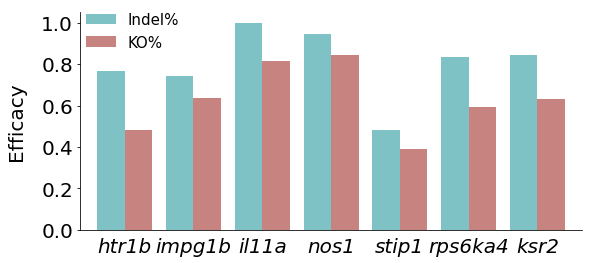

In [156]:
f, ax = plt.subplots(1,1, figsize=(9,4))
fontsize=20
df_crispr_efficiency.loc[['htr1b','impg1b','il11a','nos1','stip1','rps6ka4','ksr2']].plot.bar(width=0.8,ax=ax, color = ['#7fc2c6', '#c6837f'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(['htr1b', 'impg1b','il11a','nos1','stip1','rps6ka4','ksr2'], style='italic',rotation=0, size=fontsize)
ax.set_yticks(np.arange(0,1.1,0.2))
ax.set_yticklabels(np.arange(0,1.1,0.2).round(1), size=fontsize)
ax.set_xlabel("")
ax.set_ylabel("Efficacy",size=fontsize,labelpad=15)
ax.legend(frameon=False, fontsize=fontsize-5, ncol=1, loc=[0.0, 0.8])
plt.show()

In [150]:
df_ice_summary.reset_index(inplace=True)
df_ice_summary.index = df_ice_summary.reset_index()[['gene','probe']].apply('_'.join, axis=1)

df_temp = pd.read_excel('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Crispr/data/gRNA_design/Cas9_crRNA_genes_20220804.xlsx', skiprows=1)

df_temp.index = df_temp['Gene Symbol']+'_'+df_temp['Design ID'].str.split('.').str[-1]

df_corr = pd.concat((df_ice_summary, 
           df_temp[['On-Target Score', 'Efficiency', 'score_crisprscan']].loc[df_temp.index.unique()].dropna()),
                                   axis=1).dropna()
                                   

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


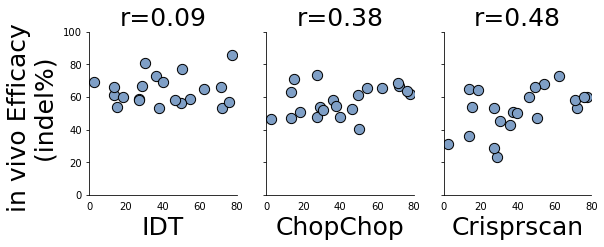

In [155]:
f, ax = plt.subplots(1,3, figsize=(9,3) ,sharey=True)
plt.subplots_adjust(wspace=0.2)
fontsize1=25
fontsize2=10
scores = ['IDT', 'ChopChop','Crisprscan']
for i, score in enumerate(df_corr.columns[4:]):
    ax[i].scatter(df_corr['ICE'], df_corr[score], color='#7f9fc6',edgecolor='black', s=105)
    ax[i].set_ylim(0,100)
    ax[i].set_xlim(0,100)
    ax[i].set_title('r='+str(df_corr.corr().iloc[0, 2+i].round(2)), size=fontsize1)
    ax[i].set_xlabel(scores[i], size=fontsize1)
    ax[i].set_xticklabels(np.arange(0,120,20),size=fontsize2)
    ax[i].set_yticklabels(np.arange(0,120,20),size=fontsize2)
    if i == 0 :
        ax[i].set_ylabel("in vivo Efficacy \n (indel%)", size=fontsize1)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

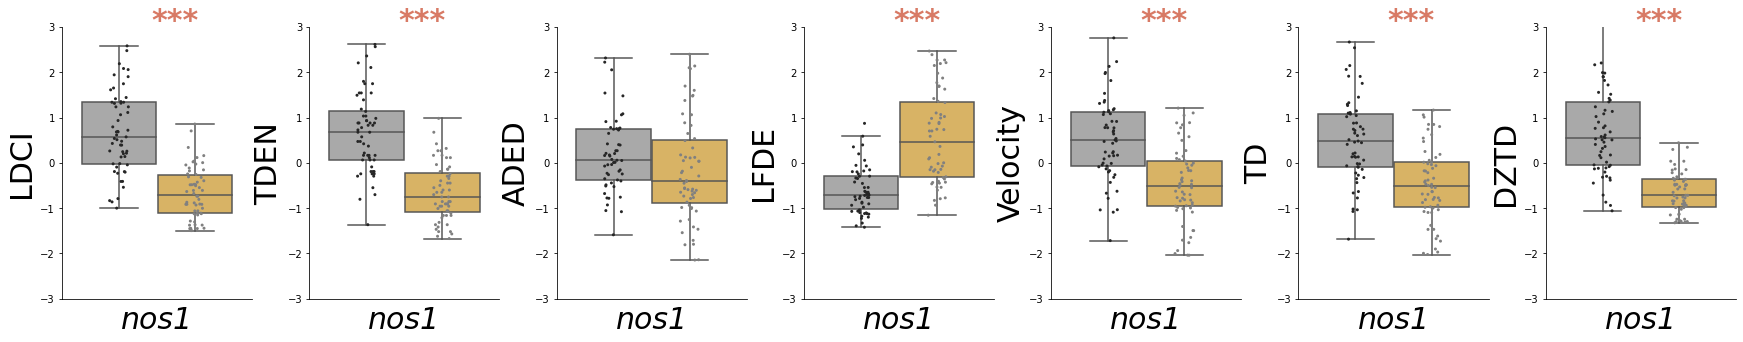

In [62]:
df_normalized_stats = df_normalized_stats.loc[df_normalized_stats['Cat']!='Cas9']
gene_order = ['nos1']
df_normalized_stats['Gene_cat'] = pd.Categorical(
    df_normalized_stats['Gene'], 
    categories=gene_order, 
    ordered=True
)
df_normalized_stats = df_normalized_stats.loc[df_normalized_stats['Gene'].isin(gene_order)]
df_normalized_stats = df_normalized_stats.sort_values('Gene_cat')
fig, ax = plt.subplots(1, 7, figsize=(30, 5))
plt.subplots_adjust(wspace=0.3)
for i, trait in enumerate(df_normalized_stats.columns[:7]):
    df_plot = df_normalized_stats[[trait, 'Cat', 'Gene']]
    sns.stripplot(x='Gene', y=trait, hue='Cat',data=df_plot, 
                  jitter=True,dodge=True, marker='o', color='grey', edgecolor='grey',
                  ax=ax[i], size=3)
    
    sns.boxplot(x='Gene', y=trait, hue='Cat',
                data=df_plot, ax=ax[i], showfliers = False, color='#cd834d',
                width=0.8)
    ax[i].legend("",frameon=False, loc = [0, 0.9])
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_ylim(-3, 3)
    for box1, box2 in zip(ax[i].artists[::2],ax[i].artists[1::2]):
        box1.set_facecolor('#a9a9a9')
        box2.set_facecolor('#d8b365')
    ax[i].set_xticks(np.arange(0,len(gene_order)))

    ax[i].set_xticklabels(gene_order, style='italic',size=30)
    ax[i].set_xlabel("")
    ax[i].set_ylabel(trait, size=30)
    symbol_list= []
    for gene in gene_order:
        x=gene_order.index(gene)*(1/len(gene_order))+0.47
        y=0.99
        df_temp = dic_stats_test[gene]
        symbol = df_temp.loc[df_temp['parameter']==trait].iloc[0,-1]
        if symbol != 'ns':
            ax[i].text(x,y,symbol,transform = ax[i].transAxes, color='#d87a65', size=30, fontweight="bold")
    
plt.show()

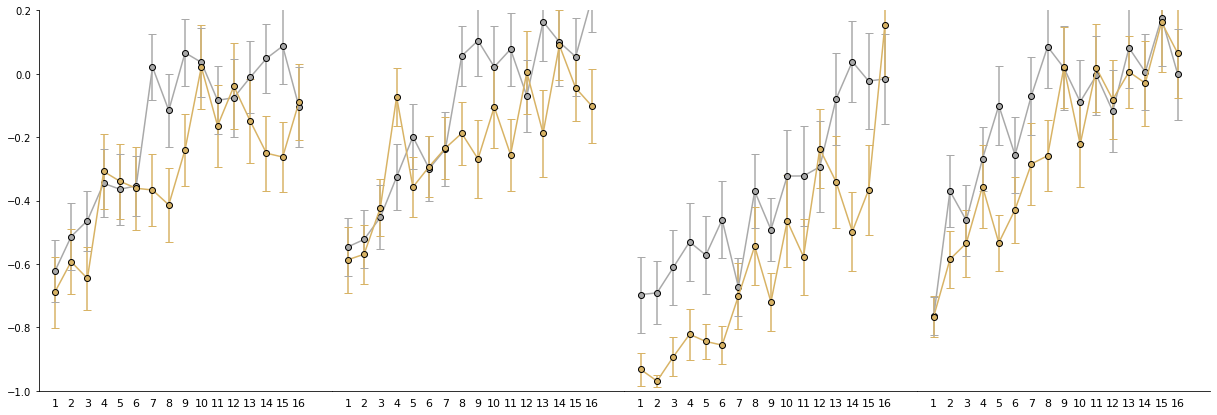

In [138]:
gene_order = ['ksr2']
fig, ax = plt.subplots(len(gene_order),4,figsize=(21,7))
plt.subplots_adjust(hspace=0.4, wspace=0)
colors = ['#a9a9a9','#d8b365']
for i, gene in enumerate(gene_order):
    df = df_bin_ldci.loc[df_bin_ldci['Gene']==gene]
    for trial in range(4):
        for group in ['Control', 'RNP']:
            
            df_bin_ci = df.loc[df['Cat']== group]
            df_bin_ci = df_bin_ci.loc[:, df_bin_ci.columns.str.contains(str(trial+1)+'-')]
            df_bin_ci.mean().plot(marker='o',yerr=df_bin_ci.sem(), ax = ax[trial],capsize=4,label=group, 
                                  color=colors[['Control', 'RNP'].index(group)], mec='black')

            
            ax[trial].spines['top'].set_visible(False)
            ax[trial].spines['right'].set_visible(False)
            if trial>0:
                ax[trial].legend("",frameon=False, loc='upper left')
                ax[trial].spines['left'].set_visible(False)
                ax[trial].axes.yaxis.set_ticks([])
                ax[trial].set_ylabel("")
            else:
                ax[trial].set_ylabel("")
                ax[trial].legend("",frameon=False, loc='upper left', fontsize=20)
                
            ax[trial].set_xticks(np.arange(0,16))
            ax[trial].set_xticklabels(labels=np.arange(1,17), fontsize=11)
            ax[trial].set_xlim(-1,17)
            ax[trial].set_ylim(-1,0.2)
            #ax[trial].set_xlabel(gene, size=30,style = 'italic')
            #if i == 0:
                #ax[trial].set_title('Trial '+str(trial+1),size=30)